# Comparing Latitude in actual data to E and temperature range

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import scipy.stats as stats

%matplotlib inline

## Making data frame with E values and variances and temperature ranges of the fluxnet data

In [2]:
actual_df = pd.read_csv("../Results/median_temps/sites_boltz_fit_median_temps_only_results.csv")
fluxnet_df = pd.read_pickle("../Data/median_temps/fluxnet_median_temps_only.pkl")

# Making a data frame of the site IDs and their corresponding E simulated and E actual.

E_vals = pd.DataFrame({'siteID' : actual_df.site_ID, 'E_actual' : actual_df.E, 
                       'lat': actual_df.lat})

# removing any values that are Nan and the outlying E values (<= 0)
E_vals = E_vals[E_vals.siteID.notnull()]
E_vals = E_vals[E_vals.E_actual.notnull()]
E_vals = E_vals[(E_vals.E_actual > 0) & (E_vals.E_actual < 2)]

In [3]:
E_vals['abs_lat'] = np.abs(np.round(E_vals.lat, 0))
E_vals['lat_range'] = [np.nan] * len(E_vals.abs_lat)
E_vals['var_E_actual'] = [np.nan] * len(E_vals.abs_lat)

E_vals = E_vals.sort_values(by = 'abs_lat', ascending = True)
E_vals = E_vals.reset_index(drop = True)

lat_bins = []

i = 0
while i < len(E_vals.abs_lat):
    # if there are still 10 observations left in the dataset, do this
    if i <= (len(E_vals.abs_lat) - 25):
        # adding the latitudinal range to the subset of entries
        E_vals.lat_range.iloc[i : i + 25] = [str(int(min(E_vals.abs_lat.iloc[i:i+25]))) + '-' + 
                                             str(int(max(E_vals.abs_lat.iloc[i:i+25])))] * len(E_vals.abs_lat.iloc[i:i+25])
        # adding the variance in E from the actual data to the subset of entries
        E_vals.var_E_actual.iloc[i:i+25] = np.var(np.array(E_vals.E_actual.iloc[i:i+25])) * len(E_vals.abs_lat.iloc[i:i+25])
        
        lat_bins.append(max(E_vals.abs_lat.iloc[i:i+25]) - min(E_vals.abs_lat.iloc[i:i+25]))
        
    # otherwise, just use the rest of the observations in the data and do the 
    # same thing as above
    else:
        # getting the number of observations remaining
        length = len(E_vals.abs_lat) - i
        # adding the latitudinal range to the subset of entries
        E_vals.lat_range.iloc[i:i + length] = [str(int(min(E_vals.abs_lat.iloc[i:i+length]))) + '-' + 
                                                 str(int(max(E_vals.abs_lat.iloc[i:i+length])))] * len(E_vals.abs_lat.iloc[i:i+length])
        
        # adding the variance in E from the actual data to the subset of entries
        E_vals.var_E_actual.iloc[i:i+length] = np.var(np.array(E_vals.E_actual.iloc[i:i + length])) * len(E_vals.abs_lat.iloc[i:i+length])
   
        lat_bins.append(max(E_vals.abs_lat.iloc[i:i+25]) - min(E_vals.abs_lat.iloc[i:i+25]))

    i = i + 25

lat_bins = np.array(lat_bins)

/home/cmee10/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Comparing the fitted E values and their variance across absolute latitude

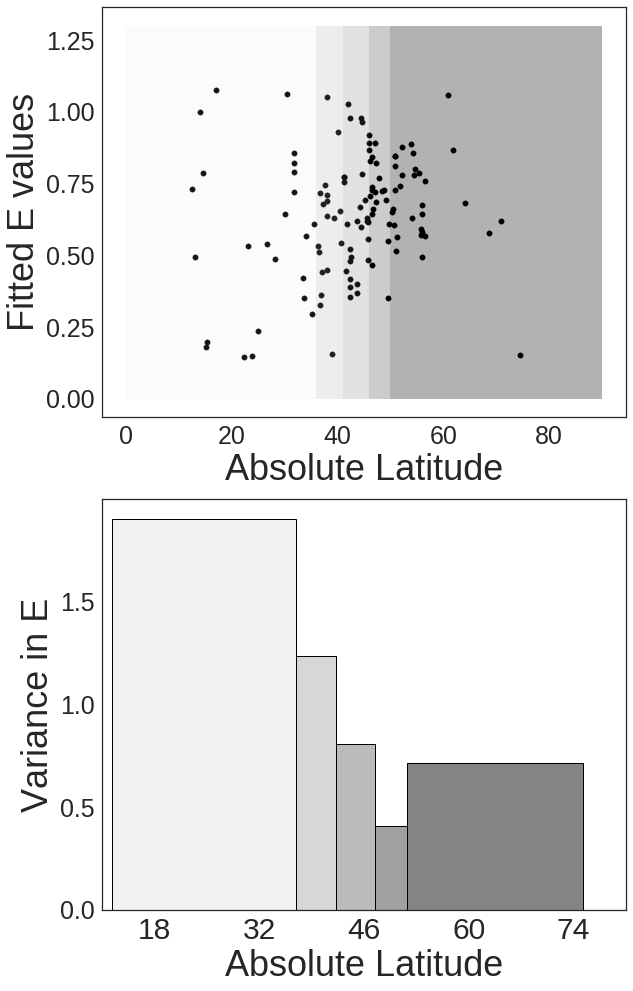

In [15]:
E_vals = E_vals.sort_values(by = 'lat_range', ascending = True)

boundaries = [0, lat_bins[0] + 13, lat_bins[0] + 13 + lat_bins[1], lat_bins[0] + 13 + lat_bins[1] + lat_bins[2], 
                    lat_bins[0] + 13 + lat_bins[1] + lat_bins[2] + lat_bins[3], 90]

with plt.style.context("seaborn-white"):
    paper_rc = {'lines.linewidth': 3, 'lines.markersize': 5}            
    sns.set(font_scale=2.5, style = 'white', rc = paper_rc) 
    fig, ax = plt.subplots(figsize = (9, 14))
    fig.tight_layout()

    ax1 = plt.subplot(2, 1, 1)
    plt.fill([boundaries[0], boundaries[1], boundaries[1], boundaries[0]], [0, 0, 1.3, 1.3], 
             'gainsboro', alpha = 0.1)
    plt.fill([boundaries[1], boundaries[2], boundaries[2], boundaries[1]], 
             [0, 0, 1.3, 1.3], 'darkgray', alpha = 0.2)
    plt.fill([boundaries[2], boundaries[3], boundaries[3], boundaries[2]], 
             [0, 0, 1.3, 1.3], 'dimgray', alpha = 0.2)
    plt.fill([boundaries[3], boundaries[4], boundaries[4], boundaries[3]], 
             [0, 0, 1.3, 1.3], 'black', alpha = 0.2)
    plt.fill([boundaries[4], boundaries[5], boundaries[5], boundaries[4]], [0, 0, 1.3, 1.3], 
             'black', alpha = 0.3)
    plt.scatter(np.abs(E_vals.lat), E_vals.E_actual, color = 'black', s = 30)
    #plt.title('Comparing Actual E values against absolute lat.', 
     #         fontsize = 18)
    plt.xlabel('Absolute Latitude', fontsize = 36)
    plt.ylabel('Fitted E values', fontsize = 36)
    low_lat = mpatches.Patch(color='gainsboro', alpha = 0.2, label='Tropical Lats')
    mid_lat = mpatches.Patch(color = 'darkgray', alpha = 0.2, label = 'Mid Lats')
    upper_lat = mpatches.Patch(color = 'dimgray', alpha = 0.2, label = 'Upper Lats')
    #plt.legend(bbox_to_anchor=(-0.1, 1.0), handles=[low_lat, mid_lat, upper_lat])

    ax2 = plt.subplot(2, 1, 2)
    pal = sns.light_palette("dimgray")
    ax2 = sns.barplot(x = E_vals.lat_range, y = E_vals.var_E_actual, palette = pal, linewidth = 1, edgecolor = 'black')
    ax2.set_ylabel('Variance in E', fontsize = 36)
    ax2.set_xlabel('Absolute Latitude', fontsize = 36)
    ax2.set_xticklabels(pd.Series.unique(E_vals.lat_range).tolist(),fontsize = 14)
    
     # Set these based on your column counts
    max_val = max(lat_bins)
    diffs = lat_bins - max_val
    diffs_prop = diffs/max_val
    new_lat_bins = np.array([100]*len(lat_bins)) + diffs_prop*100
    columncounts = new_lat_bins

    # Maximum bar width is 1. Normalise counts to be in the interval 0-1. Need to supply a maximum possible count here as maxwidth
    def normaliseCounts(widths,maxwidth):
        widths = np.array(widths)/float(maxwidth)
        return widths

    widthbars = normaliseCounts(columncounts,100)

        # Loop over the bars, and adjust the width (and position, to keep the bar centred)
    i = 0
    for bar,newwidth in zip(ax2.patches,widthbars):
        if i == 0:
            x = bar.get_x()
            prev_x = x + newwidth*1.75
            width = bar.get_width()
            centre = x + newwidth*1.75/2
            
        else:
            x = prev_x + newwidth*1.75
            prev_x = x
            centre = x-newwidth*1.75/2.
        width = bar.get_width()
                
        
        
        bar.set_x(centre-newwidth*1.75/2.)
        bar.set_width(newwidth*1.75)
        i += 1

    ax2.set_xticklabels((np.array(range(0, 90))*(74/5) + 18).astype('int'),fontsize = 30)   

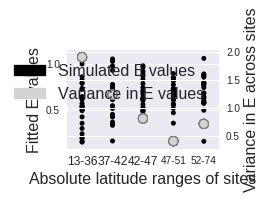

In [5]:
    ax3 = plt.subplot(2, 2, 3)
    sns.stripplot(E_vals.lat_range, E_vals.E_actual, color = 'black', label = 'E values')
    ax3.set_xlabel('Absolute latitude ranges of sites', fontsize = 16)
    ax3.set_xticklabels(['0-30 (Tropical Lat)','31-60 (Mid Lat)', '61-90 (Upper Lat)'],fontsize = 12)
    ax3.set_ylabel('Fitted E values', fontsize = 16)
    #ax3.set_title('Randomly sampled same number of sites \nfrom Mid lat and Tropical lat',
             #    fontsize = 18)
    ax4 = ax3.twinx()
    sns.stripplot(E_vals.lat_range, E_vals.var_E_actual, color = 'lightgrey', size = 9, linewidth = 1)
    ax4.set_ylabel('Variance in E across sites', fontsize = 16)

    blue_patch = mpatches.Patch(color='black', label='Simulated E values')
    black_patch = mpatches.Patch(color = 'lightgrey', label = 'Variance in E values')
    plt.legend(handles=[blue_patch, black_patch], fontsize = 16)
    

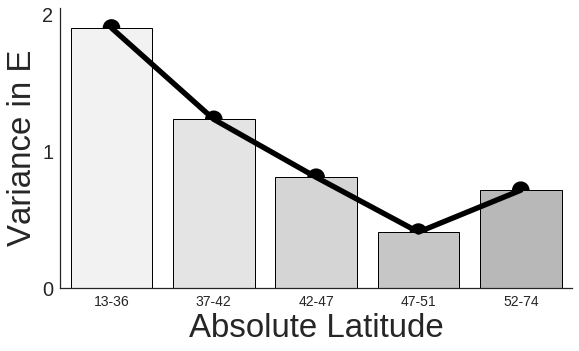

In [6]:
pal = sns.light_palette("darkgray")
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 5}            
sns.set(font_scale=3, style = 'white', rc = paper_rc) 
ax2 = sns.FacetGrid(E_vals, size = 6, aspect = 1.5)
ax2 = ax2.map(sns.barplot, 'lat_range', 'var_E_actual', palette = pal, linewidth = 1, edgecolor = 'black')
ax2 = ax2.map(sns.pointplot,  'lat_range', 'var_E_actual', color = 'black')
ax2.set_axis_labels("Absolute Latitude","Variance in E")
ax2.set_xticklabels(pd.Series.unique(E_vals.lat_range).tolist(),fontsize = 14)
p_trop_mid = 0.043565
ax2.set_yticklabels(fontsize = 20)

## Running a Bartlett's test for homogeneity of variance across the three latitudinal groups

In [7]:
lat_ranges = list(pd.Series.unique(E_vals.lat_range))

zer_one = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[0], 'E_actual'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[1], 'E_actual'])
print('zer_one: ' + str(zer_one))

zer_two = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[0], 'E_actual'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[2], 'E_actual'])
print('zer_two: ' + str(zer_two))

zer_three = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[0], 'E_actual'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[3], 'E_actual'])
print('zer_three: ' + str(zer_three))

zer_four= stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[0], 'E_actual'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[4], 'E_actual'])
print('zer_four' + str(zer_four))

one_two = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[1], 'E_actual'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[2], 'E_actual'])
print('one_two' + str(one_two))

one_three = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[1], 'E_actual'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[3], 'E_actual'])
print('one_three' + str(one_three))

one_four = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[1], 'E_actual'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[4], 'E_actual'])
print('one_four' + str(one_four))

two_three = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[2], 'E_actual'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[3], 'E_actual'])
print('two_three' + str(two_three))

two_four = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[2], 'E_actual'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[4], 'E_actual'])
print('two_four' + str(two_four))

three_four = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[3], 'E_actual'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[4], 'E_actual'])
print('three_four' + str(three_four))

zer_one: BartlettResult(statistic=1.0951862302944466, pvalue=0.29532495793160207)
zer_two: BartlettResult(statistic=4.166153310371036, pvalue=0.04123932797075041)
zer_three: BartlettResult(statistic=12.74346937165928, pvalue=0.0003572543873227702)
zer_fourBartlettResult(statistic=4.2772613566621409, pvalue=0.038625535393313093)
one_twoBartlettResult(statistic=1.0344406254260006, pvalue=0.30911796965402405)
one_threeBartlettResult(statistic=6.855867436190322, pvalue=0.0088350653133974794)
one_fourBartlettResult(statistic=1.1646900918415841, pvalue=0.28049497604807683)
two_threeBartlettResult(statistic=2.7086130328612783, pvalue=0.099807733348181757)
two_fourBartlettResult(statistic=0.0080158493917539663, pvalue=0.92865969868610787)
three_fourBartlettResult(statistic=2.3369591154140861, pvalue=0.12633595862039776)
